## Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, classification_report

from scipy.stats import friedmanchisquare

## Load Data
**Please Provide the file path\***

In [ ]:
data = pd.read_csv('data.csv')

## Dataset Overview

In [6]:
info = data.info()

print('\n+++ N/A values +++')
print(data.isna().any())

print('\n Null Values ++')
print(data.isnull().any())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 7 columns):
username             999895 non-null object
password             999700 non-null object
publisher            1000000 non-null object
register_datetime    1000000 non-null object
domain               1000000 non-null object
partner              1000000 non-null object
is_fake              1000000 non-null int64
dtypes: int64(1), object(6)
memory usage: 53.4+ MB

+++ N/A values +++
username              True
password              True
publisher            False
register_datetime    False
domain               False
partner              False
is_fake              False
dtype: bool

 Null Values ++
username              True
password              True
publisher            False
register_datetime    False
domain               False
partner              False
is_fake              False
dtype: bool


## Data Visualization
 - Check class distribution
 - Sample distribution for fake

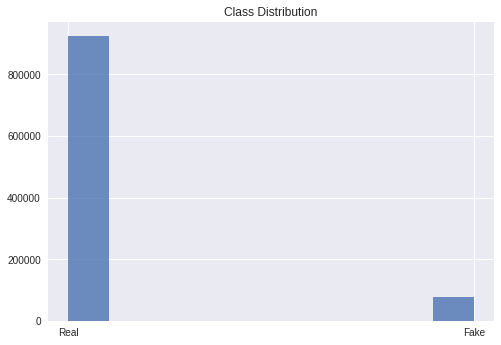

In [24]:
# plot the distribution of classes
plt.hist(data.is_fake,alpha=0.8)
plt.xticks([0,1],['Real','Fake'])
plt.title('Class Distribution')
plt.show()

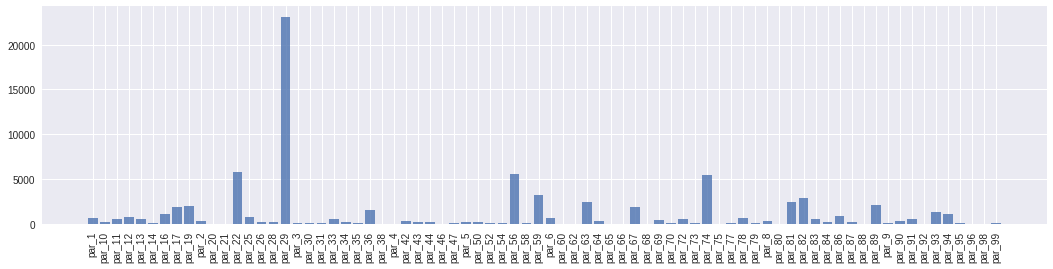

In [34]:
# plot distribution for fake 
fake = data[data.is_fake==1]
uniq_ = np.unique(fake['partner'])

freq_ = np.zeros(len(uniq_))

for i in range(len(uniq_)):
  freq_[i] = np.shape(fake.values[fake['partner']==uniq_[i]])[0]

plt.figure(figsize=(18,4))
plt.bar(np.arange(len(uniq_)), freq_, alpha=0.8)
plt.xticks(np.arange(len(uniq_)),uniq_,rotation=90)
plt.title('Partner for fake samples')
plt.show()

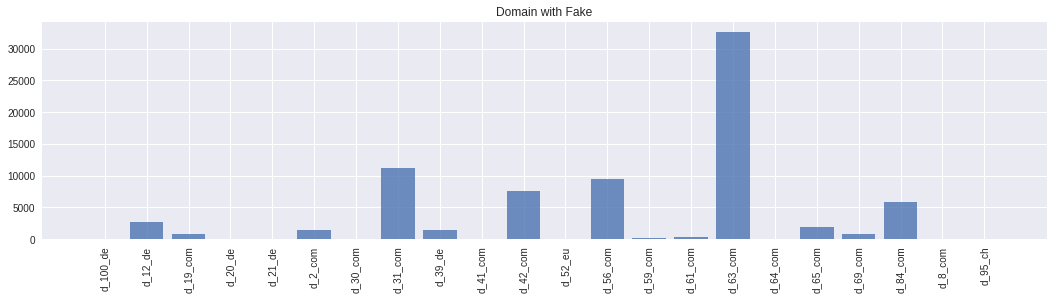

In [35]:
uniq_ = np.unique(fake['domain'])

freq_ = np.zeros(len(uniq_))

for i in range(len(uniq_)):
  freq_[i] = np.shape(fake.values[fake['domain']==uniq_[i]])[0]

plt.figure(figsize=(18,4))
plt.bar(np.arange(len(uniq_)), freq_, alpha=0.8)
plt.xticks(np.arange(len(uniq_)),uniq_,rotation=90)
plt.title('Domain  for fake samples')
plt.show()

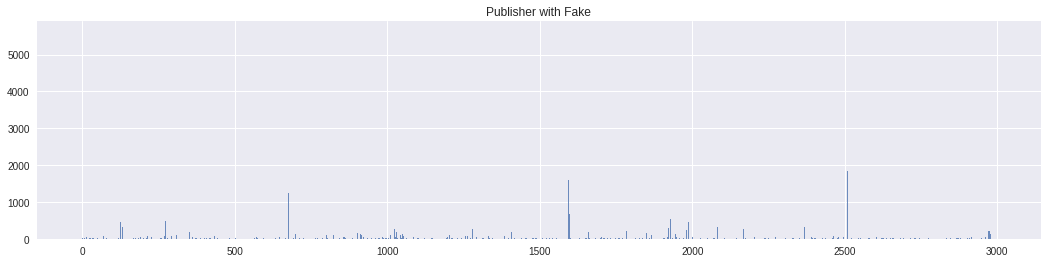

In [37]:
uniq_ = np.unique(fake['publisher'])

freq_ = np.zeros(len(uniq_))

for i in range(len(uniq_)):
  freq_[i] = np.shape(fake.values[fake['publisher']==uniq_[i]])[0]

plt.figure(figsize=(18,4))
plt.bar(np.arange(len(uniq_)), freq_, alpha=0.8)
# plt.xticks(np.arange(len(uniq_)),rotation=90)
plt.title('Publisher  for fake samples')
plt.show()

## Comments
 - Imbalanced classes: The classes are unqually distributed and we need to incorporate it in out analysis. Accuracy will not be good measure, so we will use F1 score.
 - Certain values are more frequent than others in the featues. A good idea would be to try naive bayesian to exploit this information using prior prababilites.

## Pre-processing 
 - Prepare the data for classification
 - Features we will be working with are partner, domain and publisher

In [45]:
#pre-process
publisher_encoder = LabelEncoder()
domain_encoder = LabelEncoder()
partner_encode = LabelEncoder()

processed_data = data
processed_data.is_copy = True
processed_data['publisher'] = publisher_encoder.fit_transform(data['publisher'])
processed_data['domain'] = domain_encoder.fit_transform(data['domain'])
processed_data['partner'] = partner_encode.fit_transform(data['partner'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/in

## Random Forests

In [55]:
cv = StratifiedKFold(5)
X = processed_data[['publisher','domain','partner']]
y = processed_data['is_fake']

clf_rf = RandomForestClassifier(n_jobs=-1)#,class_weight='balanced'
score_rf = []
for train, test in cv.split(X,y):
  X_train = X.values[train]
  X_test = X.values[test] 
  y_train = y.values[train] 
  y_test = y.values[test]
  
  clf_rf.fit(X_train,y_train)
  
  y_pred = clf_rf.predict(X_test)
  
  score_rf.append(f1_score(y_test,y_pred))
  
print(score_rf)

[0.29656182157822997, 0.24375423590175047, 0.42708144932778686, 0.32379329356924463, 0.25098421767759466]


In [49]:
clf_rf.feature_importances_
'''
Comment: The random forests uses decision trees which are biased towards 
features with most categories. Domain and partner have comparatively very few
categories than publisher (~10,000 categories). Therefore, the trained random
forest suggests publisher as the most important feature.
'''

array([0.73410709, 0.04743505, 0.21845787])

## Naive Bayes

In [51]:
clf_nb = MultinomialNB()#,class_weight='balanced'
score_nb = []
for train, test in cv.split(X,y):
  X_train = X.values[train]
  X_test = X.values[test] 
  y_train = y.values[train] 
  y_test = y.values[test]
  
  clf_nb.fit(X_train,y_train)
  
  y_pred = clf_nb.predict(X_test)
  
  score_nb.append(f1_score(y_test,y_pred))
  
print(score_nb)

[0.13279928447823297, 0.15224259009598168, 0.08761579594808323, 0.13800454803865836, 0.14666306536364976]


## Sub-sampling
 - Clearly from the results, random forests are better than Naive Bayesian classifiers
 - Now, we will take random forests and try subsampling approaches.

In [56]:
index_0 = np.where(y==0)[0]
index_1 = np.where(y==1)[0]
#sub sampling the majority class
for i in [0.1,0.3,0.5,0.7]:
  print('+++++++{}++++++++'.format(i))
  #Shape of is_fake==0
  shape_0 = np.shape(index_0)[0]
  
  random_sample = np.random.choice(shape_0,int(shape_0*i),replace=False)
  
  sub_samples = np.append(index_0[random_sample],index_1,axis=0)
  
  np.random.shuffle(sub_samples)
  
  X_sub = X.values[sub_samples]
  y_sub = y.values[sub_samples]
  
  
  
  cv = StratifiedKFold(4)

  clf_rf = RandomForestClassifier(n_jobs=-1)
  score = []
  for train, test in cv.split(X_sub,y_sub):
    X_train = X_sub[train]
    X_test = X_sub[test] 
    y_train = y_sub[train] 
    y_test = y_sub[test]

    clf_rf.fit(X_train,y_train)

    y_pred = clf_rf.predict(X_test)
    print(classification_report(y_test,y_pred))
    score.append(f1_score(y_test,y_pred))
  print('\n \n')
  print(score)

+++++++0.1++++++++
             precision    recall  f1-score   support

          0       0.75      0.93      0.83     23100
          1       0.88      0.63      0.73     19003

avg / total       0.81      0.79      0.79     42103

             precision    recall  f1-score   support

          0       0.75      0.93      0.83     23100
          1       0.88      0.62      0.73     19003

avg / total       0.81      0.79      0.78     42103

             precision    recall  f1-score   support

          0       0.75      0.93      0.83     23099
          1       0.88      0.63      0.73     19003

avg / total       0.81      0.79      0.79     42102

             precision    recall  f1-score   support

          0       0.75      0.93      0.83     23099
          1       0.87      0.62      0.73     19003

avg / total       0.80      0.79      0.78     42102


 

[0.7308566165182684, 0.7258274048871017, 0.7306984165950656, 0.7271945715250699]
+++++++0.3++++++++
             prec

## Comments
The subsampling of real (is_fake = 0) for 0.1 has better results when compared to the other methods. 